# Weight initialization

## follow the explanation here

https://adventuresinmachinelearning.com/weight-initialization-tutorial-tensorflow/


In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [14]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.1.0'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
%matplotlib inline

In [2]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print("dimension de las imagenes y las clases", X.shape, y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train
X_test  = X_test
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print(X_train.shape, y_train_oh.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)
(1200, 784) (1200, 10)


# load data and train a simple model

In [12]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32')

In [56]:
def get_model(input_dim=784, output_dim=10, layer_sizes=[10]*6, activation="relu", sigma=1):
    
    model = Sequential()
    init1k = keras.initializers.RandomNormal(mean=.0, stddev=sigma, seed=None)
    init1b = keras.initializers.RandomNormal(mean=.0, stddev=sigma, seed=None)

    model.add(Dense(layer_sizes[0], activation=activation, input_dim=input_dim, name="Layer_%02d_Input"%(0),
                    kernel_initializer=init1k,
                    bias_initializer=init1b,
                    dtype=tf.float64
                ))

   
    for i, hsize in enumerate(layer_sizes[1:]):
        model.add(Dense(hsize, activation=activation, name="Layer_%02d_Hidden"%(i+1), dtype=tf.float64))
   
    model.add(Dense(output_dim, activation="softmax", name="Layer_%02d_Output"%(len(layer_sizes)), dtype=tf.float64))
        
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.reset_states()
    return model

def get_gradients_functions(model):
    T_input     = model.input                                        
    T_outputs   = [layer.output for layer in model.layers]         
    T_weights   = model.trainable_weights
    T_outputs   = [layer.output for layer in model.layers]

    F_outputs   = [K.function([T_input], [out]) for out in T_outputs]    

    def get_gradients_functions(model):
        r = []
        for i in range(len(model.trainable_variables)):
            def f(X,y,i=eval("i")):
                v = model.trainable_variables[i]
                with tf.GradientTape(persistent=True) as t:
                    loss = model.loss_functions[0]( model(X), y)
                return t.gradient(loss,v).numpy()
            r.append(f)
        return r

    F_gradients = get_gradients_functions(model)

    return T_input, T_outputs, T_weights, F_outputs, F_gradients

In [57]:
model = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=20)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_00_Input (Dense)       (None, 20)                15700     
_________________________________________________________________
Layer_01_Hidden (Dense)      (None, 15)                315       
_________________________________________________________________
Layer_02_Hidden (Dense)      (None, 15)                240       
_________________________________________________________________
Layer_03_Output (Dense)      (None, 10)                160       
Total params: 16,415
Trainable params: 16,415
Non-trainable params: 0
_________________________________________________________________


In [58]:
T_input, T_outputs, T_weights, F_outputs, F_gradients = get_gradients_functions(model)

In [59]:
T_outputs

[<tf.Tensor 'Layer_00_Input_12/Identity:0' shape=(None, 20) dtype=float64>,
 <tf.Tensor 'Layer_01_Hidden_12/Identity:0' shape=(None, 15) dtype=float64>,
 <tf.Tensor 'Layer_02_Hidden_12/Identity:0' shape=(None, 15) dtype=float64>,
 <tf.Tensor 'Layer_03_Output_12/Identity:0' shape=(None, 10) dtype=float64>]

In [60]:
model.get_config()

{'name': 'sequential_13',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'Layer_00_Input',
    'trainable': True,
    'batch_input_shape': (None, 784),
    'dtype': 'float64',
    'units': 20,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'RandomNormal',
     'config': {'mean': 0.0, 'stddev': 20, 'seed': None}},
    'bias_initializer': {'class_name': 'RandomNormal',
     'config': {'mean': 0.0, 'stddev': 20, 'seed': None}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'Layer_01_Hidden',
    'trainable': True,
    'dtype': 'float64',
    'units': 15,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularize

In [61]:
T_input, T_outputs, T_weights, F_outputs, F_gradients = get_gradients_functions(model)

In [63]:
scale_X=.2
shift_X =.5
!rm -rf log
tb_callback = keras.callbacks.TensorBoard(log_dir='./log/winit', histogram_freq=1,  write_grads=True, write_graph=True, write_images=True)
model.fit((X_train-shift_X)*scale_X, y_train_oh, epochs=30, batch_size=32,
          validation_data=((X_test-shift_X)*scale_X, y_test_oh), 
         )#callbacks=[tb_callback])




W0220 18:01:42.370362 4512175552 callbacks.py:1501] `write_grads` will be ignored in TensorFlow 2.0 for the `TensorBoard` Callback.


Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 0s 55us/sample - loss: 2.3233 - accuracy: 0.1250 - val_loss: 2.3084 - val_accuracy: 0.1133
Epoch 2/30
1200/1200 [==============================] - 0s 50us/sample - loss: 2.3017 - accuracy: 0.1267 - val_loss: 2.2955 - val_accuracy: 0.1133
Epoch 3/30
1200/1200 [==============================] - 0s 46us/sample - loss: 2.2905 - accuracy: 0.1267 - val_loss: 2.2887 - val_accuracy: 0.1133
Epoch 4/30
1200/1200 [==============================] - 0s 46us/sample - loss: 2.2835 - accuracy: 0.1267 - val_loss: 2.2841 - val_accuracy: 0.1133
Epoch 5/30
1200/1200 [==============================] - 0s 52us/sample - loss: 2.2796 - accuracy: 0.1267 - val_loss: 2.2812 - val_accuracy: 0.1133
Epoch 6/30
1200/1200 [==============================] - 0s 50us/sample - loss: 2.2750 - accuracy: 0.1283 - val_loss: 2.2758 - val_accuracy: 0.1133
Epoch 7/30
1200/1200 [==============================] - 0s 55us/sample 

# Effects of different initializations

understand carefully the following function

check the notebook on **Inspecting model internals** to understand `get_tensors_and_functions` and the objects it returns

In [20]:
def train_experiment(model, sigma, X_train, X_test):
    model = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=sigma)
    T_input, T_outputs, T_weights, F_outputs, F_gradients = get_gradients_functions(model)

    w0_before = model.get_weights()[0].reshape(-1)
    o0_before = F_outputs[0]([X_train])[0].reshape(-1)
    g0_before = F_gradients[0](X_train, y_train_oh).reshape(-1)
    
    model.fit(X_train, y_train_oh, epochs=30, batch_size=32, 
              validation_data=(X_test, y_test_oh), verbose=0)

    w0_after = model.get_weights()[0].reshape(-1)
    o0_after = F_outputs[0]([X_train])[0].reshape(-1)
    g0_after = F_gradients[0](X_train, y_train_oh).reshape(-1)

    acc, val_acc = model.history.history["accuracy"], model.history.history["val_accuracy"]

    plt.figure(figsize=(20,3))
    plt.subplot(141)
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="test_acc")
    plt.legend();
    plt.grid()
    plt.title("sigma=%.2f"%(sigma))
    plt.xlabel("epoch")
    plt.subplot(142)
    plt.hist(w0_after, bins=30, density=True, label="after", alpha=.5);
    plt.hist(w0_before, bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 weights")

    plt.subplot(143)
    plt.hist(o0_after, bins=30, density=True, label="after", alpha=.5);
    plt.hist(o0_before, bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 outputs")
    
    plt.subplot(144)

    def get_percentile(k, perc=90):
        p = np.percentile(np.abs(k), [perc])[0]
        return k[(k>-p)&(k<p)]

    plt.hist(get_percentile(g0_after), bins=30, density=True, label="after", alpha=.5);    
    plt.hist(get_percentile(g0_before), bins=30, density=True, label="before", alpha=.5);
    plt.legend();
    plt.title("layer 0 gradients")

### initializing with a standard normal ($\mu=0$ and $\sigma=1$)

histograms show weights, outputs and gradients before and after training

in good configurations:
- weights move during training
- gradients are spread around zero before training
- outputs before training are spread

In [21]:
model = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=0.1)


In [22]:
model.outputs[0]

<tf.Tensor 'Layer_03_Output_2/Identity:0' shape=(None, 10) dtype=float32>

W0220 17:53:06.399342 4512175552 base_layer.py:1790] Layer Layer_00_Input is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



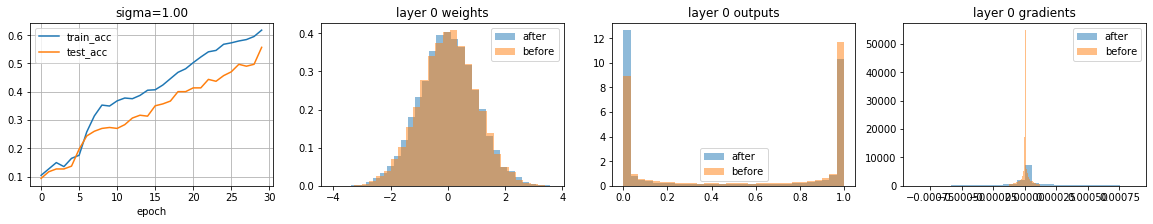

In [23]:
train_experiment(model, sigma=1, X_train=X_train, X_test=X_test)

### initializing with a small $\sigma$


W0220 17:57:46.492722 4512175552 base_layer.py:1790] Layer Layer_00_Input is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



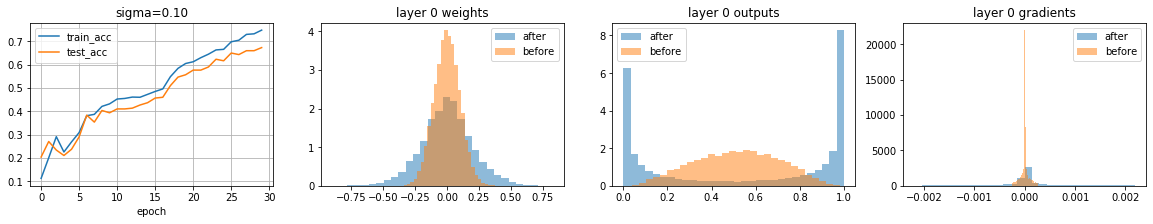

In [27]:
train_experiment(model, sigma=.1, X_train=X_train, X_test=X_test)

### initializing with a large $\sigma$

observe how gradients are very concentrated arounz zero at the beginning of training

W0220 17:53:34.143740 4512175552 base_layer.py:1790] Layer Layer_00_Input is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



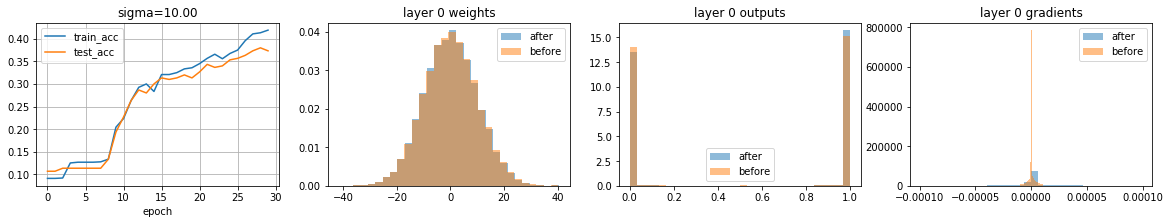

In [25]:
train_experiment(model, sigma=10, X_train=X_train, X_test=X_test)

### initializing with a small $\sigma$ but with large values for input data

Recall that $XW+b$ is what enters the $sigmoid$ function. If large, it will be away from the linear regine around zero. It can be large because of $W$ (large initialization $\sigma$), or because of $X$.


W0220 17:51:39.917109 4736255424 base_layer.py:1790] Layer Layer_00_Input is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



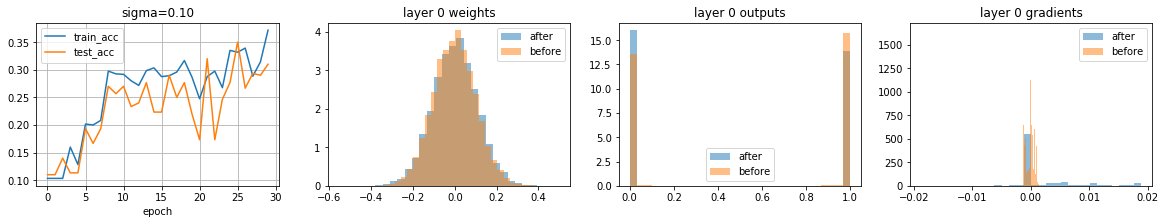

In [51]:
train_experiment(model, sigma=.1, X_train=X_train*100-50, X_test=X_test*100-50)